# Meeting 1
-----
### Objectives
- Establish initial research questions, hypotheses, and story.
- Discuss issues in the NLP literature.
- Agree upon impending experiments and try to secure computing resources.
- Discuss preliminary results.
-----
### Conclusions
- The initial story: it's well-known that the rigor of the NLP literature is in a paltry state. We point out various issues in the current literature. Contrary to popular belief, it's completely fine to tune the random seed, but it depends on what you want, what you measure, and what you report. We describe a sound experimental procedure for testing several important quantities. We apply this procedure to several relevant models.
- Reproducibility should be regarded more highly.
- Estimate the required compute time for our experiments.
- Pool our computing resources on Vector.
-----
### Is it okay to tune the random seed?
Conventional wisdom says no -- see Goldberg (2017) and Crane (2018). We say yes, but it depends on what you want, what you measure, and what you report.

### Well, doesn't it hurt generalization?

/home/ralph/programming/sigtestv/data
         === ESIM ===
       ep80 ep2080  ep20
dev  0.8757 0.8699 0.8629
test 0.873  0.8724 0.8705
         === SSE ===
       ep80 ep2080  ep20
dev  0.8842 0.8806 0.8774
test 0.8801 0.8795 0.8796


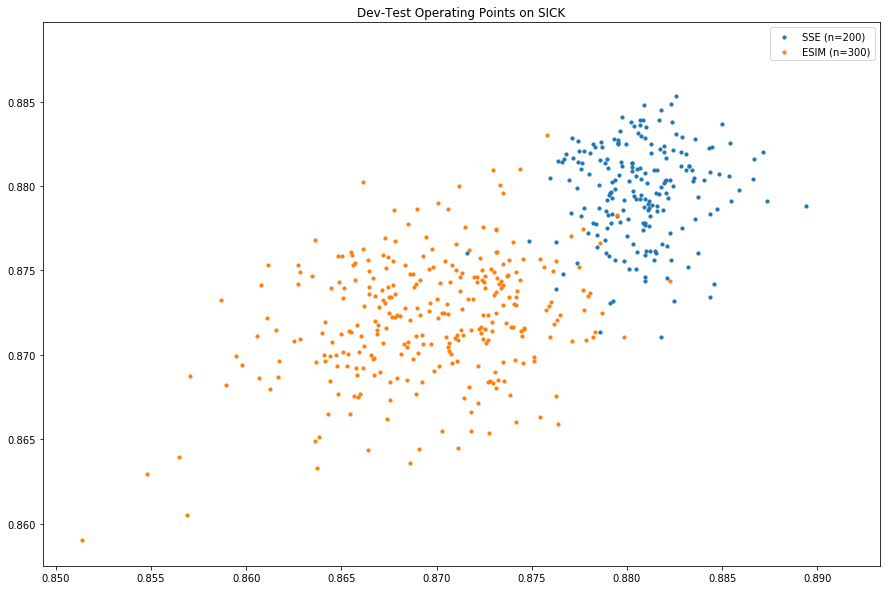

(0.0851268596900739, 0.2307199245030127)
(0.2973899838896502, 1.5320240838370534e-07)


In [204]:
%cd ~/programming/sigtestv/data
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

def display_quartiles(arr, title, qs=(0.2, 0.8)):
    pl, pu = np.quantile(arr[0], qs)
    dev_meanu, test_meanu = np.mean(arr[:, arr[0] > pu], axis=1)
    dev_meanlu, test_meanlu = np.mean(arr[:, np.bitwise_and(arr[0] < pu, arr[0] > pl)], axis=1)
    dev_meanl, test_meanl = np.mean(arr[:, arr[0] < pl], axis=1)
    pl100 = int(qs[0] * 100)
    pu100 = int(qs[1] * 100)
    print(f'         === {title} ===')
    print(f'       ep{pu100} ep{pl100}{pu100}  ep{pl100}')
    print(f'dev  {dev_meanu:<6.4} {dev_meanlu:<6.4} {dev_meanl:<6.4}')
    print(f'test {test_meanu:<6.4} {test_meanlu:<6.4} {test_meanl:<6.4}')

plt.rcParams["figure.figsize"] = (15, 10)

sse_df = pd.read_csv('sse.csv')
esim_df = pd.read_csv('esim.csv')
sse_arr = np.array([sse_df['dev'], sse_df['test']])
esim_arr = np.array([esim_df['dev'], esim_df['test']])

display_quartiles(esim_arr, 'ESIM')
display_quartiles(sse_arr, 'SSE')

fig, ax = plt.subplots()
ax.scatter(sse_df['dev'], sse_df['test'], s=10, label=f'SSE (n={len(sse_df)})')
ax.scatter(esim_df['dev'], esim_df['test'], s=10, label=f'ESIM (n={len(esim_df)})')
ax.legend()
plt.title('Dev-Test Operating Points on SICK')
plt.show()

print(pearsonr(sse_df['dev'], sse_df['test']))
print(pearsonr(esim_df['dev'], esim_df['test']))

### Quantities of Interest
- $E[X], Q(0.2), Q(0.5), Q(0.8)$: robustness vs. performance.

_t_-test (paired and unpaired), ANOVA, Tukey's, and other parametric tests are widely accepted to be okay for $E[X]$.

What about quantiles? Is subsampling bootstrap the best we can do?

### Preliminary BiRNN runs on SST-2

306


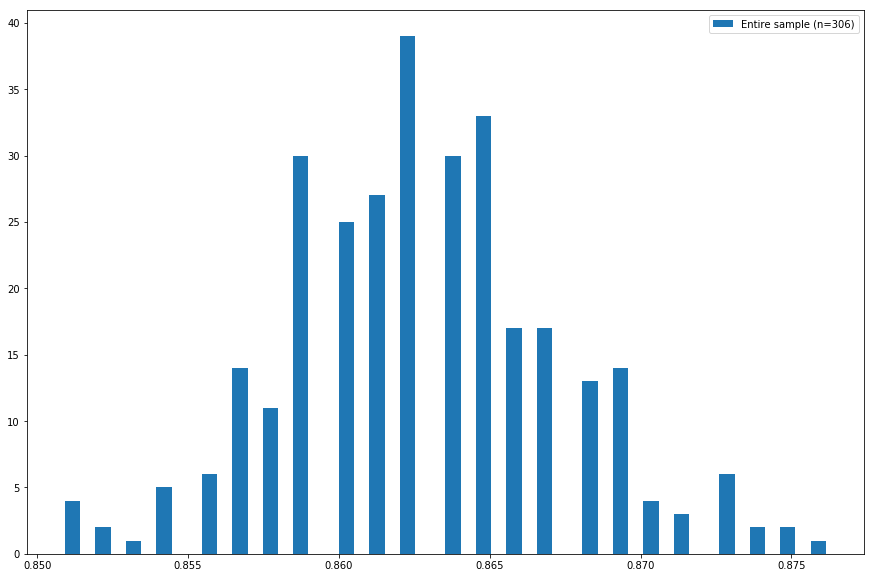

[0.85894495 0.86238532 0.86697248]


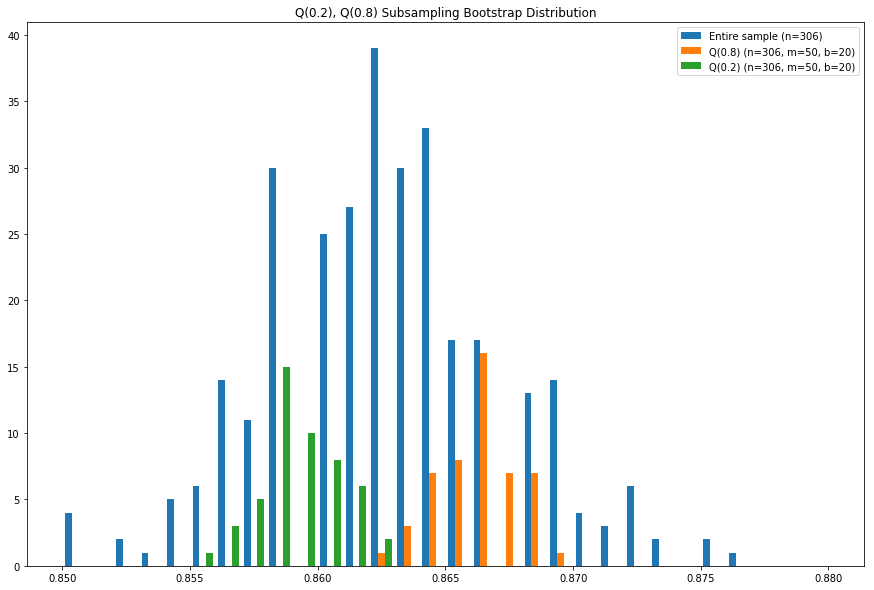

In [207]:
from matplotlib import pyplot
from scipy.stats import shapiro

def quantile_bootstrap_sample(x, q, n=50, m=20):
    samples = [np.random.choice(x, m, replace=False) for _ in range(n)]
    return np.quantile(samples, q, axis=1)

birnn_df = pd.read_csv('birnn-sst2.tsv', sep='\t', quoting=3)
print(len(birnn_df))
fig, ax = plt.subplots()
ax.hist(birnn_df['result'], bins=50, label='Entire sample (n=306)')
ax.legend()
plt.show()
print(np.quantile(birnn_df['result'], (0.2, 0.5, 0.8)))

fig, ax = plt.subplots()
labels = ('Entire sample (n=306)', 'Q(0.8) (n=306, m=50, b=20)', 'Q(0.2) (n=306, m=50, b=20)')
ax.hist([birnn_df['result'], quantile_bootstrap_sample(birnn_df['result'], 0.8), quantile_bootstrap_sample(birnn_df['result'], 0.2)],
        bins=30, label=labels, range=(0.85, 0.88))
ax.legend()
plt.title('Q(0.2), Q(0.8) Subsampling Bootstrap Distribution')
plt.show()

### Preliminary BERT runs on SST-2

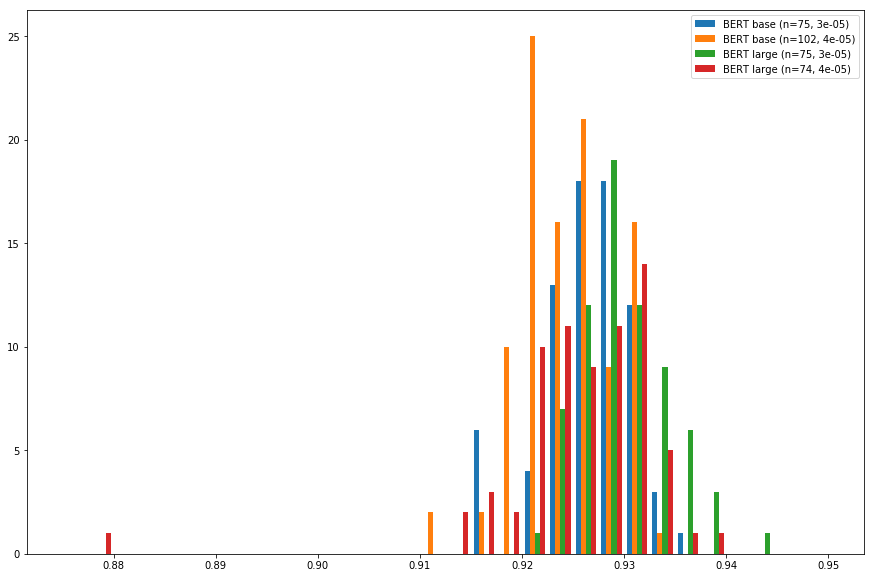

In [206]:
df_filenames = [f'bbase-sst2-{lr}.tsv' for lr in (3e-05, 4e-05)]
df_filenames.extend([f'blarge-sst2-{lr}.tsv' for lr in (3e-05, 4e-05)])

dfs = [pd.read_csv(df, sep='\t', quoting=3) for df in df_filenames]
fig, ax = plt.subplots()
labels = ('BERT base (n={n}, 3e-05)', 'BERT base (n={n}, 4e-05)', 'BERT large (n={n}, 3e-05)', 'BERT large (n={n}, 4e-05)')
data = []
ax_labels = []
for df, label in zip(dfs, labels):
    ax_labels.append(label.format(n=len(df['result'])))
    data.append(df['result'])
plt_range = (0.875, 0.95)
# plt_range = (0.5, 0.95)
ax.hist(data, bins=30, label=ax_labels, range=plt_range, histtype='bar')
ax.legend()
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

-----
### Q: Is significance testing, well, significant?
### Simple A: Yes, how do we know the differences in results didn't arise by chance?
### Q: Should we treat previous results in the literature as true population parameters?
### Simple A: No, the true parameter is never observed.
So why is the natural language processing field the way it is?
- Laziness, ignorance, apathy, and pressure to publish quickly.
- Poor precedence.
### Call to action
Researchers should...
- make a concerted effort to reproduce past results.
- release the full sample across the random seeds that they tested on.
- correct for multiple comparisons.
- release the environment used to train their models.

Of course, significance testing is not a panacea for producing good research.

-----

### References
Goldberg, Y. 2017. Neural Network Methods for Natural Language Processing. _Synthesis Lectures on HLT_.

Crane, M. 2018. Questionable Answers in Question Answering Research: Reproducibility and Variability of Published Results. _TACL_.